In [1]:
!python -V

Python 3.9.12


Ejecutando MLflow desde bash con backend en sqlite

```bash
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [ ]:
# !pip install mlflow==2.13.0

## No queremos estar repitiendo la ejecución de este proceso celda por celda
---

Vamos a crear funciones para este proceso

In [2]:
# los más de los duros, los reales, los meros buenos
import pandas as pd
import numpy as np

# para graficar
import matplotlib.pyplot as plt
import seaborn as sns   

# libreria que usaremos para aprendizaje
import sklearn

# para preprocesamiento
from sklearn.feature_extraction import DictVectorizer

# los modelos
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# las metricas
from sklearn.metrics import mean_squared_error

# !!! New stuff after adding mlflow
import mlflow

# para las advertencias (NO USAR EN PROD!!!!)
import warnings
warnings.filterwarnings("ignore")

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/learning-mlops/02-exp-tracking/mlruns/1', creation_time=1716326305194, experiment_id='1', last_update_time=1716326305194, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
# la funcion para leer los datos
def leer_dataframe(filename):

    df = pd.read_parquet(filename)

    # parseamos el string a datetime
    
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df["duration"] = df.duration.apply(lambda x: x.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    # convirtiendo la duracion a segundos
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)

    return df
    

In [5]:
df_train = leer_dataframe('../01-intro/data/green_tripdata_2021-01.parquet')
df_val = leer_dataframe('../01-intro/data/green_tripdata_2021-02.parquet')
print(df_train.shape, df_val.shape)

(73908, 21) (61921, 21)


In [6]:
print(df_train.PULocationID.nunique())
print(df_train.DOLocationID.nunique())

250
256


In [7]:
print(df_val.PULocationID.nunique())
print(df_val.DOLocationID.nunique())

245
254


In [8]:
# creando un nuevo feature
df_train["PU_LO"] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val["PU_LO"] = df_val.PULocationID + '_' + df_val.DOLocationID

In [9]:
categorical = ["PU_LO"] #"PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

In [10]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts) # OJO aqui solo usamos transform

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [11]:
print(X_train.shape, y_train.shape)

(73908, 13221) (73908,)


In [12]:
print(X_val.shape, y_val.shape)

(61921, 13221) (61921,)


In [13]:
# entrenando Regresion Lineal
rl = LinearRegression()
rl.fit(X_train, y_train)

y_pred_rl = rl.predict(X_val)

print(mean_squared_error(y_val, y_pred_rl, squared=False))

7.758715203341164


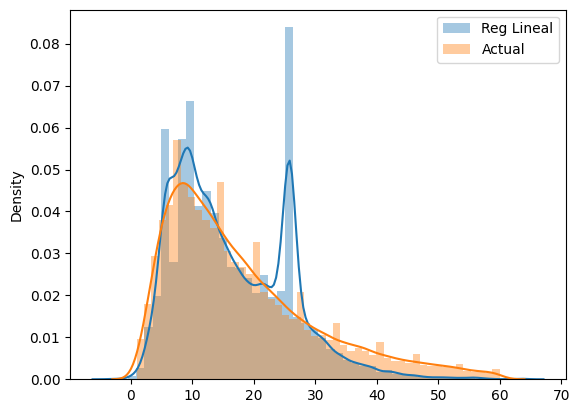

In [14]:
sns.distplot(y_pred_rl, label='Reg Lineal')
sns.distplot(y_val, label='Actual')
plt.legend();

In [15]:
# entrenando Regresion Lineal
rl_lasso = Lasso()
rl_lasso.fit(X_train, y_train)

y_pred_lasso = rl_lasso.predict(X_val)

print(mean_squared_error(y_val, y_pred_lasso, squared=False))

12.212583224318818


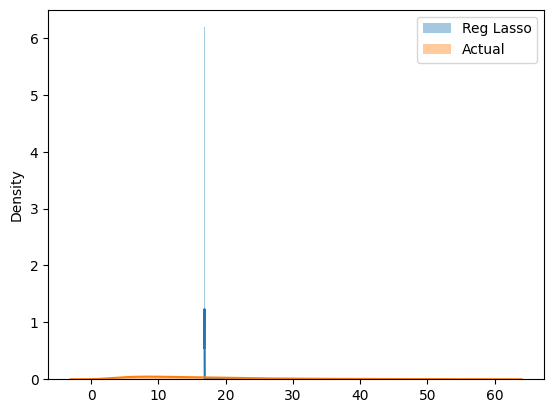

In [16]:
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_val, label='Actual')
plt.legend();

## Guardando los modelos

In [26]:
import pickle
with open("models/lin_reg.bin", "wb") as f:
    pickle.dump((dv, rl), f)

entrenando Regresion Lasso

```
rl_lasso = Lasso(0.001)
rl_lasso.fit(X_train, y_train)
y_pred_lasso = rl_lasso.predict(X_val)
```

In [23]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'carlos ceron')
    mlflow.set_tag('model','lasso reg')
    # sobre simplificacion de versionamiento de datos
    mlflow.log_param("train-data-path", "../01-intro/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "../01-intro/data/green_tripdata_2021-02.parquet")
    
    alpha = 0.001
    mlflow.log_param("alpha", alpha)

    # Llevando seguimiento del entrenamiento en MLflow
    lasso = Lasso(alpha)
    lasso.fit(X_train, y_train)

    y_pred_lasso = lasso.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred_lasso, squared=False)

    mlflow.log_metric("rmse", rmse)

In [24]:
print(rmse)

9.233436225720547


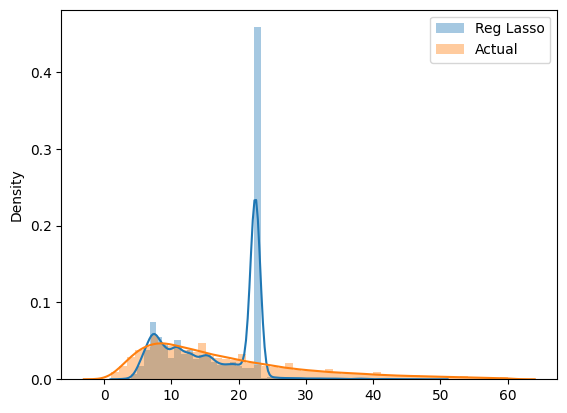

In [25]:
sns.distplot(y_pred_lasso, label='Reg Lasso')
sns.distplot(y_val, label='Actual')
plt.legend();

## Entrenando otro tipo de modelo para comparat

In [26]:
#!pip install xgboost
import xgboost as xgb

In [27]:
# !pip install hyperopt
# libreria que usa metodos bayesianos para encontrar la mejor combinacion de hiperparametros
# el modelo se convierte en una funcion que tiene inputs y produce outputs
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# fmin: funcion para minimizar el objetivo
# tpe: algorimo que controla esta logiva
# hp: libreria que contiene metodos para definir los rangos de los hiperparametros. Define el espacio de busqueda.
# STATUS_OK: senal que mandaremos al final de cada corrida, para que hyperopt sepa que la funcion objetivo se ejecuto correctamente
# Trials: llevara registro de la informacion de cada corrida
# scope: la usaremos para definir un rango de typo int


In [36]:
xgb_train_set = xgb.DMatrix(X_train, label=y_train)
xgb_val_set = xgb.DMatrix(X_val, label=y_val) 

In [37]:
# primero tenemos que definir la funcion objetivo

def funcion_objetivo(parametros, train_set=xgb_train_set, validation_set=xgb_val_set):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(parametros)

        xg = xgb.train(
            params=parametros,
            dtrain=train_set,
            num_boost_round=1000,
            evals=[(validation_set,"validation")],
            early_stopping_rounds=50
        )

        y_pred = xg.predict(validation_set)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {"loss": rmse, "status": STATUS_OK}

In [38]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), # exp(-3) hasta exp(0) - (0.05, 1.0)
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -1, 3),
    "objective": "reg:linear",
    "seed": 42,
}

In [39]:
best_result = fmin(
    fn=funcion_objetivo,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

[22:29:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

[0]	validation-rmse:17.07876                          
[1]	validation-rmse:14.03855                          
[2]	validation-rmse:11.83020                          
[3]	validation-rmse:10.25458                          
[4]	validation-rmse:9.15069                           
[5]	validation-rmse:8.38951                           
[6]	validation-rmse:7.87376                           
[7]	validation-rmse:7.52472                           
[8]	validation-rmse:7.28451                           
[9]	validation-rmse:7.12123                           
[10]	validation-rmse:7.00646                          
[11]	validation-rmse:6.92792                          
[12]	validation-rmse:6.87195                          
[13]	validation-rmse:6.83115                          
[14]	validation-rmse:6.80093                          
[15]	validation-rmse:6.77513                          
[16]	validation-rmse:6.75669                          
[17]	validation-rmse:6.74348                          
[18]	valid

In [42]:
## Choosing the best parameters
best_params = {
"learning_rate": 0.11665465693180731,
"max_depth": 39,
"min_child_weight": 1.699112908194548,
"objective": "reg:linear",
"reg_alpha": 0.0877938168395368,
"reg_lambda": 0.26227785341843785
}

mlflow.set_tag("model", "best_xgboost")
mlflow.log_params(best_params)

xg = xgb.train(
    params=best_params,
    dtrain=xgb_train_set,
    num_boost_round=1000,
    evals=[(xgb_val_set,"validation")],
    early_stopping_rounds=50
)

y_pred = xg.predict(xgb_val_set)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

[22:54:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10690
[1]	validation-rmse:17.29069
[2]	validation-rmse:15.71108
[3]	validation-rmse:14.34112
[4]	validation-rmse:13.15956
[5]	validation-rmse:12.14354
[6]	validation-rmse:11.27300
[7]	validation-rmse:10.52887
[8]	validation-rmse:9.89523
[9]	validation-rmse:9.35700
[10]	validation-rmse:8.90500
[11]	validation-rmse:8.52353
[12]	validation-rmse:8.20128
[13]	validation-rmse:7.92971
[14]	validation-rmse:7.70468
[15]	validation-rmse:7.51429
[16]	validation-rmse:7.35484
[17]	validation-rmse:7.22239
[18]	validation-rmse:7.11004
[19]	validation-rmse:7.01559
[20]	validation-rmse:6.93572
[21]	validation-rmse:6.86875
[22]	validation-rmse:6.81142
[23]	validation-rmse:6.76311
[24]	validation-rmse:6.72134
[25]	validation-rmse:6.68556
[26]	validation-rmse:6.65546
[27]	valida

`USING AUTOLOG`

In [56]:
!pip install xgboost --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.6.0
    Uninstalling xgboost-1.6.0:
      Successfully uninstalled xgboost-1.6.0


In [58]:
import xgboost
xgboost.__version__

'1.6.0'

In [45]:
## Choosing the best parameters
best_params = {
"learning_rate": 0.11665465693180731,
"max_depth": 39,
"min_child_weight": 1.699112908194548,
"objective": "reg:linear",
"reg_alpha": 0.0877938168395368,
"reg_lambda": 0.26227785341843785
}

mlflow.xgboost.autolog

xg = xgb.train(
    params=best_params,
    dtrain=xgb_train_set,
    num_boost_round=2,
    evals=[(xgb_val_set,"validation")],
    early_stopping_rounds=50
)

2024/05/21 23:07:17 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0
2024/05/21 23:07:17 WARNING mlflow.xgboost: Unable to log dataset information to MLflow Tracking.XGBoost version must be >= 1.7.0


[23:07:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.10690
[1]	validation-rmse:17.29069


2024/05/21 23:07:22 ERROR mlflow.xgboost: Failed to log feature importance plot. XGBoost autologging will ignore the failure and continue. Exception: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 674, in train_impl
    log_feature_importance_plot(features, importance, imp_type)
  File "/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/xgboost/__init__.py", line 573, in log_feature_importance_plot
    mlflow.log_artifact(filepath)
  File "/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/tracking/fluent.py", line 1068, in log_artifact
    MlflowClient().log_artifact(run_id, local_path, artifact_path)
  File "/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/tracking/client.py", line 1878, in log_artifact
    self._tracking_client.log_artifact(run_id, local_path, artifact_path)
  File "/opt/anaconda3/envs/mlops/lib/python3.9/site-packages/mlflow/tracking/_tracking_servic

In [ ]:
y_pred = xg.predict(xgb_val_set)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)